# Solving the Color Match Triangle Puzzle with Z3

I was recently given a Color Match triangle puzzle. A solution of this puzzle involves placing 16 small equilateral triangular tiles, each with three colored spots, into a container so that all adjacent tiles share a common color. There are human strategies for solving this type of problem, but most of them involve trial and error and manual backtracking, two things that humans are bad at and computers are good at.

It seemed like a good opportunity to practice solving the puzzle with an SMT solver, in this case the [Z3 theorem prover](https://github.com/Z3Prover/z3) developed by Microsoft Research.



## Tiles

The 16 tiles from my version of the puzzle (in arbitrary order) are shown below.

<img src="files/triangle_tiles.png">

## Method

The technique used was to convert the input data to a format suitable for handing to the SMT solver. 

We need to add a variable for each choice that it is possible to make.

- Each of the tiles can be inserted into the container in any order
- Each tile can be rotated into one of three orientations

We need to add a constraints that 

- Only valid tiles are considered
- Only valid rotations are considered
- Each of the tiles may only be used once
- A pair of tiles may only be in adjacent slots if the color on the shared edge is the same (accounting for rotation)
- A tile may only be in a boundary slot if the color shared with the boundary edge is the same (accounting for rotation)

### Labelling

The colors are converted to an arbitrary labelling.

The labelling of slots in the board is trivial - and is constructed top to bottom, left to right.

The labelling of edges in a triangle a taken to be 0 for the color spot along the horizontal edge, 1- and 2- are respectively for the first and second edge clockwise around the triangle. 

The labelling of rotations is trivial, and is taken to be 0 in the natural orientation, 1 if the tile is rotated once clockwise, and 2 if it rotated twice counter clockwise. 

Although it is possible to programatically create an adjacency list of which slots are internally adjacent to one another, here we choose to very explictly list them out by hand, the code to generate this list proved to be almost as long as the list it was producing.

### User Supplied data

The user must supply a list of the three colors (in clockwise order) for each tile, and the colors of each of the edges at the board boundary.

In [51]:
%matplotlib inline

In [1]:
# TODO - add diagram

# down-tri
#  1 - 2
#   \ /
#    0

# up-tri
#    0
#   / \
#  2 - 1

In [2]:


# tiles
#       0
#     1 2 3
#   4 5 6 7 8
# 9 A B C D E F

# boundaries         
#             0  4
#          1        5
#       2             6
#    3                   7
#        8   9  A  B

In [3]:
# labelling of colors
import enum 

class Color(enum.Enum):
    BLACK = 0
    GREEN = 1
    RED = 2
    YELLOW = 3
    WHITE = 4
    BLUE = 5

In [27]:
from z3 import *

In [93]:
# tile-src, tile-dst, edge
internal_table = [
    # row 0-1
    (0, 2, 0),
    
    # row 1
    (1, 2, 2),
    (2, 3, 1),
    
    # row 1-2
    (1, 5, 0),
    (3, 7, 0),
    
    # row 2
    (4, 5, 2),
    (5, 6, 1),
    (6, 7, 2),
    (7, 8, 1),
    
    # row 2-3
    (4,10,0),
    (6,12,0),
    (8,14,0),
    
    # row 3
    (9,10,2),
    (10,11,1),
    (11,12,2),
    (12,13,1),
    (13,14,2),
    (14,15,1)
]

boundary_table = [
    

    # left
    (0, 1),
    (1, 1),
    (4, 1),
    (9, 1),
    
    # right
    (0, 2),
    (3, 2),
    (8, 2),
    (15, 2),

    # bottom
    (9, 0),
    (11, 0),
    (13, 0),
    (15, 0),    
    
]

In [87]:
def rotate(seq, n):
    if n == 0:
        return seq
    if n == 1:
        return (seq[1], seq[2], seq[0])
    return (seq[2], seq[0], seq[1])

In [95]:
def boundary_constraint(colormap, pos, edge, color, tiles, rots):
    t = tiles[pos]
    r = rots[pos]
    constr = []
    for i in range(16): 
        for j in range(3):
            if color == colormap[i, (j+edge)%3]:
                row = And(t == i, r == j)
                constr += [row]
    return Or(*tuple(constr))

def internal_constraint(colormap, pos1, pos2, edge, tiles, rots):
    t1 = tiles[pos1]
    t2 = tiles[pos2]
    r1 = rots[pos1]
    r2 = rots[pos2]
    constr = []
    for i in range(16):
        for j in range(16):
            for u in range(3):
                for v in range(3):
                    c1 = colormap[(i, (u + edge) % 3)]
                    c2 = colormap[(j, (v + edge) % 3)]
                    if c1 == c2:
                        row = And(t1 == i, t2 == j, r1==u, r2==v)
                        constr += [row]
    return Or(*tuple(constr))

def string2color(s):
    return getattr(Color, s.upper()).value

def color_rotation_map(tris):
    d = {}
    for i, t in enumerate(tris):
        for j, c in enumerate(t):
            v = string2color(c)
            d[(i,j)] = v
    return d

def build_triangle_puzzle_solver(tris, boundaries):
    colormap = color_rotation_map(tris)

    # variables to represent the number of tiles in the puzzle
    tiles  = [ Int('x%d' % i) for i in range(16) ]

    # variables to represent the rotation of each tile
    rots = [ Int('r%d' % i) for i in range(16) ]

    # constraints to represent that a tile must be [0..15)
    tile_constr = [ And(t >= 0, t < 16) for t in tiles ]

    # constraints to represent that a tile map be rotated into one of three positions
    rotation_constr = [ And(r >= 0, r < 3) for r in rots ]

    # boundary constraints
    boundary_constr = []
    for i, (pos, edge) in enumerate(boundary_table):
        bcolor = string2color(boundaries[i])
        #print('pos', pos, 'edge', edge, 'color', Color(bcolor))
        c = boundary_constraint(colormap, pos, edge, bcolor, tiles, rots)
        boundary_constr += [ c ]

    # internal constraints
    internal_constr = [ ]
    for p1, p2, e in internal_table:
        c = internal_constraint(colormap, p1, p2, e, tiles, rots) 
        internal_constr += [ c ]

    s = Solver()
    s.add(tile_constr)
    s.add(rotation_constr)
    s.add([Distinct(tiles)])
    s.add(boundary_constr)
    s.add(internal_constr)
    return s, tiles, rots



In [96]:
def print_res(tris, boundary_colors):
    print('building solver')
    s, tiles, rots = build_triangle_puzzle_solver(tris, boundary_colors)
    print('start')
    if s.check() == sat:
        print('sat')
        m = s.model()
        tileids = [ m.evaluate(tiles[i]) for i in range(16) ]
        rotids  = [ m.evaluate(rots[i])  for i in range(16) ]
        ntris = []
        for i in range(16):
            tid = int(str(tileids[i]))
            rid = int(str(rotids[i]))
            t = rotate(tris[tid], rid)
            ntris.append(t)
        puzzrender.plot_board(ntris, boundary_colors)
    else:
        print('unsat')

building solver
start
sat
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


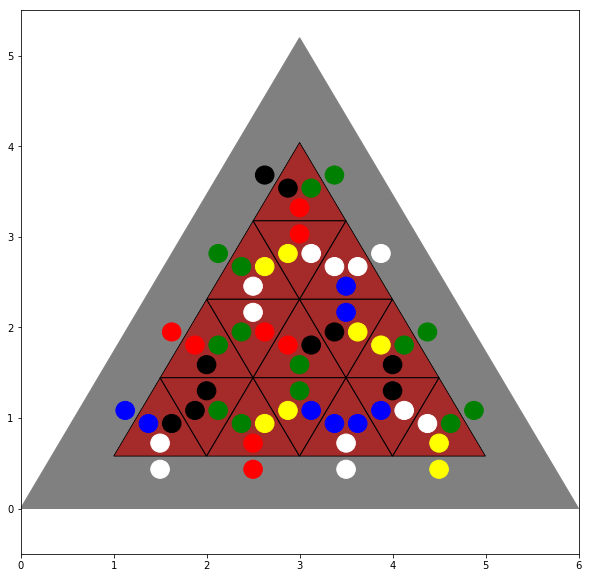

In [82]:

tris = [
    ('red', 'black', 'green'),
    ('white', 'green', 'yellow'),
    ('red', 'white', 'yellow'),
    ('blue', 'white', 'white'),
    ('black', 'red', 'green'),
    ('white', 'red', 'green'),
    ('green', 'red', 'black'),
    ('blue', 'yellow', 'black'),
    ('black', 'yellow', 'green'),
    ('white', 'blue', 'black'),
    ('black', 'green', 'black'),
    ('red', 'green', 'yellow'),
    ('green', 'blue', 'yellow'),
    ('white', 'blue', 'blue'),
    ('black', 'white', 'blue'),
    ('green', 'yellow', 'white'),
]

boundaries = [
    'black','green','red','blue',
    'green','white','green','green',
    'white','red','white','yellow'
]

print_res(tris, boundaries)

building solver
start
sat
[3, 9, 10, 15, 5, 13, 7, 1, 6, 12, 2, 8, 11, 4, 0, 14]
[1, 0, 2, 0, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 0, 0]


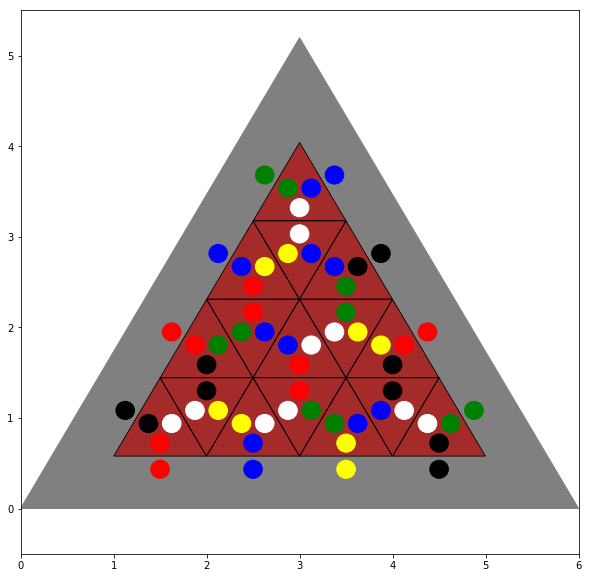

In [94]:
tris = [
    ('black', 'white', 'blue'),
    ('white', 'green', 'yellow'),
    ('white', 'black', 'yellow'),
    ('blue', 'white', 'green'),
    
    ('green', 'blue', 'yellow'),
    ('red', 'green', 'black'),
    ('red', 'black', 'yellow'),
    ('blue', 'white', 'red'),
    
    ('yellow', 'white', 'blue'),
    ('red', 'blue', 'yellow'),
    ('blue', 'yellow', 'white'),
    ('green', 'white', 'red'),
    
    ('white', 'red', 'black'),
    ('blue', 'green', 'red'),
    ('black', 'white', 'green'),
    ('green', 'blue', 'black')
]

boundary_colors = [
    'green', 'blue', 'red', 'black',
    'blue', 'black', 'red', 'green',
    'red', 'blue', 'yellow', 'black',
]

print_res(tris, boundary_colors)